# The Pythagorean Expectation
#### 觀察畢達哥拉斯期望值和勝率之間的相關性
The Pythagorean expectation can be described thus: in any season, the percentage of games won will be proportional to the square of total runs/points/goals scored by the team squared divided by the sum of total runs/points/goals scored by the team squared plus total runs/points/goals conceded by the team squared.

### wpc = TF2 / ( TF2 + TA2 )

Where TF is runs/points/goals scored and TA is runs/points/goals conceded.

In [2]:
## OLS package:https://read01.com/kznOEOg.html#.Y5LbpnZBxD8
## https://ppfocus.com/0/eddc2cb4e.html


import pandas as pd #資料處理套件
import numpy as np
import statsmodels.formula.api as smf #回歸模型套件
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1) 匯入資料

In [3]:
# log of games played in 2021
# data here: https://www.retrosheet.org/

MLB = pd.read_excel("C:/Users/USER/Desktop/AI_CLASS/coursera/GL2021.xlsx")
print(MLB)
type(MLB)


          Date  DoubleHeader DayOfWeek VisitingTeam VisitingTeamLeague  \
0     20210401             0       Thu          PIT                 NL   
1     20210401             0       Thu          SLN                 NL   
2     20210401             0       Thu          LAN                 NL   
3     20210401             0       Thu          TBA                 AL   
4     20210401             0       Thu          MIN                 AL   
...        ...           ...       ...          ...                ...   
2424  20211003             0       Sun          MIN                 AL   
2425  20211003             0       Sun          TBA                 AL   
2426  20211003             0       Sun          ANA                 AL   
2427  20211003             0       Sun          CLE                 AL   
2428  20211003             0       Sun          BAL                 AL   

      VisitingTeamGameNumber HomeTeam HomeTeamLeague  HomeTeamGameNumber  \
0                          1      C

pandas.core.frame.DataFrame

In [4]:
MLB

,Date,DoubleHeader,DayOfWeek,VisitingTeam,VisitingTeamLeague,VisitingTeamGameNumber,HomeTeam,HomeTeamLeague,HomeTeamGameNumber,VisitorRunsScored,...,HomeBatting7Name,HomeBatting7Position,HomeBatting8PlayerID,HomeBatting8Name,HomeBatting8Position,HomeBatting9PlayerID,HomeBatting9Name,HomeBatting9Position,AdditionalInfo,AcquisitionInfo
0,20210401,0,Thu,PIT,NL,1,CHN,NL,1,5,...,Jason Heyward,9,boted002,David Bote,4,hendk001,Kyle Hendricks,1,NaN,Y
1,20210401,0,Thu,SLN,NL,1,CIN,NL,1,11,...,Jonathan India,4,barnt001,Tucker Barnhart,2,castl003,Luis Castillo,1,NaN,Y
2,20210401,0,Thu,LAN,NL,1,COL,NL,1,5,...,Chris Owings,4,hampg001,Garrett Hampson,8,marqg001,German Marquez,1,NaN,Y
3,20210401,0,Thu,TBA,AL,1,MIA,NL,1,1,...,Jorge Alfaro,2,rojam002,Miguel Rojas,6,alcas001,Sandy Alcantara,1,NaN,Y
4,20210401,0,Thu,MIN,AL,1,MIL,NL,1,5,...,Omar Narvaez,2,urial001,Luis Urias,6,woodb005,Brandon Woodruff,1,NaN,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,20211003,0,Sun,MIN,AL,162,KCA,AL,162,7,...,Michael Taylor,8,albeh001,Hanser Alberto,4,gallc001,Cam Gallagher,2,NaN,Y
2425,20211003,0,Sun,TBA,AL,162,NYA,AL,162,0,...,Brett Gardner,8,sancg002,Gary Sanchez,2,odorr001,Rougned Odor,5,NaN,Y
2426,20211003,0,Sun,ANA,AL,162,SEA,AL,162,7,...,Jarred Kelenic,8,ralec001,Cal Raleigh,2,moord002,Dylan Moore,7,NaN,Y
2427,20211003,0,Sun,CLE,AL,162,TEX,AL,162,6,...,Nick Solak,10,trevj001,Jose Trevino,2,herny003,Yonny Hernandez,5,NaN,Y


# 2) 整理資料(只取需要的幾個變數)

In [5]:
# For the Pythagorean Expectation we need only runs scored and conceded. Of course, we also need the names of the teams.
# rename只需要少數幾列：主隊、客隊、主隊得分、客隊得分、比賽日期。將列重命名為更短的變量名以便於使用

MLB21 = MLB[['VisitingTeam','HomeTeam','VisitorRunsScored','HomeRunsScore','Date']]
MLB21 = MLB21.rename(columns={'VisitorRunsScored':'VisR','HomeRunsScore':'HomR'})
MLB21

,VisitingTeam,HomeTeam,VisR,HomR,Date
0,PIT,CHN,5,3,20210401
1,SLN,CIN,11,6,20210401
2,LAN,COL,5,8,20210401
3,TBA,MIA,1,0,20210401
4,MIN,MIL,5,6,20210401
...,...,...,...,...,...
2424,MIN,KCA,7,3,20211003
2425,TBA,NYA,0,1,20211003
2426,ANA,SEA,7,3,20211003
2427,CLE,TEX,6,0,20211003


In [6]:
# The variable 'hwin' is defined here as equaling 1 if the home team scored more runs, and zero otherwise. 
# The variable 'awin' is defined in a similar way for the away team.
# we also create a 'counter' variable = 1 for each row. (用來計算場次數)
# 使用 np.where(condition, x, y) Numpy 方法將勝利分為兩個不同的列：主隊勝利和客隊勝利
# 满足條件(condition)，輸出x，不滿足則输出y。

MLB21['hwin']= np.where(MLB21['HomR']>MLB21['VisR'],1,0)
MLB21['awin']= np.where(MLB21['HomR']<MLB21['VisR'],1,0)
MLB21['count']=1
MLB21

,VisitingTeam,HomeTeam,VisR,HomR,Date,hwin,awin,count
0,PIT,CHN,5,3,20210401,0,1,1
1,SLN,CIN,11,6,20210401,0,1,1
2,LAN,COL,5,8,20210401,1,0,1
3,TBA,MIA,1,0,20210401,0,1,1
4,MIN,MIL,5,6,20210401,1,0,1
...,...,...,...,...,...,...,...,...
2424,MIN,KCA,7,3,20211003,0,1,1
2425,TBA,NYA,0,1,20211003,1,0,1
2426,ANA,SEA,7,3,20211003,0,1,1
2427,CLE,TEX,6,0,20211003,0,1,1


# 2-1) 主隊資料整理

In [7]:
# groupby 用法: https://www.learncodewithmike.com/2021/04/pandas-groupby-and-aggregate-method.html
# 通過對DataFrame對象調用groupby()函數返回的結果是一個DataFrameGroupBy對象，而不是一個DataFrame或者Series對象，需要按照GroupBy對像中具有的函數和方法進行調用。
# 定義兩個 df，一個用於主隊，一個用於客隊，然後我們可以合併它們以獲得得失分
# reset-讓index重置，前面出現 0 1 2 .....
MLBhome = MLB21.groupby('HomeTeam')[['hwin','HomR','VisR','count']].sum().reset_index() #在 groupby 方法後使用雙括號。單括號用於輸出 Pandas Series，雙括號用於輸出 Pandas DataFrame。
MLBhome = MLBhome.rename(columns={'HomeTeam':'team','VisR':'VisRh','HomR':'HomRh','count':'Gh'})
MLBhome

,team,hwin,HomRh,VisRh,Gh
0,ANA,39,381,399,81
1,ARI,32,369,442,81
2,ATL,42,404,352,80
3,BAL,27,362,507,81
4,BOS,49,470,402,81
5,CHA,53,416,303,81
6,CHN,39,369,428,81
7,CIN,44,448,413,81
8,CLE,40,342,359,81
9,COL,48,456,407,81


# 2-2)客隊資料整理

In [8]:
MLBvis = MLB21.groupby("VisitingTeam")[["awin","HomR","VisR","count"]].sum().reset_index()
MLBvis = MLBvis.rename(columns={'VisitingTeam':'team','VisR':'VisRa','HomR':'HomRa','count':'Ga'})
MLBvis

,team,awin,HomRa,VisRa,Ga
0,ANA,38,405,342,81
1,ARI,20,451,310,81
2,ATL,46,304,386,81
3,BAL,25,449,297,81
4,BOS,43,347,359,81
5,CHA,40,333,380,81
6,CHN,32,411,336,81
7,CIN,39,347,338,81
8,CLE,40,368,375,81
9,COL,26,389,283,80


# 2-3) 勝敗球隊資料合併

In [9]:
# We now merge MLBhome and MLBvis so that we have a list of all the clubs with home and away records for the 2021 season
MLB21 = pd.merge(MLBhome,MLBvis, on="team")
MLB21

,team,hwin,HomRh,VisRh,Gh,awin,HomRa,VisRa,Ga
0,ANA,39,381,399,81,38,405,342,81
1,ARI,32,369,442,81,20,451,310,81
2,ATL,42,404,352,80,46,304,386,81
3,BAL,27,362,507,81,25,449,297,81
4,BOS,49,470,402,81,43,347,359,81
5,CHA,53,416,303,81,40,333,380,81
6,CHN,39,369,428,81,32,411,336,81
7,CIN,44,448,413,81,39,347,338,81
8,CLE,40,342,359,81,40,368,375,81
9,COL,48,456,407,81,26,389,283,80


In [10]:
MLB21['W']=MLB21['hwin']+MLB21['awin'] #總勝場
MLB21['G']=MLB21['Gh']+MLB21['Ga'] # 總比賽場次
MLB21['RS']=MLB21['HomRh']+MLB21['VisRa'] # 總得分
MLB21['RA']=MLB21['VisRh']+MLB21['HomRa'] # 總失分
MLB21

,team,hwin,HomRh,VisRh,Gh,awin,HomRa,VisRa,Ga,W,G,RS,RA
0,ANA,39,381,399,81,38,405,342,81,77,162,723,804
1,ARI,32,369,442,81,20,451,310,81,52,162,679,893
2,ATL,42,404,352,80,46,304,386,81,88,161,790,656
3,BAL,27,362,507,81,25,449,297,81,52,162,659,956
4,BOS,49,470,402,81,43,347,359,81,92,162,829,749
5,CHA,53,416,303,81,40,333,380,81,93,162,796,636
6,CHN,39,369,428,81,32,411,336,81,71,162,705,839
7,CIN,44,448,413,81,39,347,338,81,83,162,786,760
8,CLE,40,342,359,81,40,368,375,81,80,162,717,727
9,COL,48,456,407,81,26,389,283,80,74,161,739,796


In [11]:
# The last step in preparing the data is to define win percentage and the Pythagorean Expectation （棒球畢氏定理）.
# 帶入公式
## WPCT = 勝場 ÷ （勝場 + 敗場）
## 勝率 = 總得分的平方除以總得分與總失分的平方- RS ^ 2 / （RS ^ 2 + RA ^ 2）

MLB21['wpc'] = MLB21['W']/MLB21['G']
MLB21['pyth'] = MLB21['RS']**2/(MLB21['RS']**2 + MLB21['RA']**2)
MLB21

,team,hwin,HomRh,VisRh,Gh,awin,HomRa,VisRa,Ga,W,G,RS,RA,wpc,pyth
0,ANA,39,381,399,81,38,405,342,81,77,162,723,804,0.475309,0.447104
1,ARI,32,369,442,81,20,451,310,81,52,162,679,893,0.320988,0.366345
2,ATL,42,404,352,80,46,304,386,81,88,161,790,656,0.546584,0.591880
3,BAL,27,362,507,81,25,449,297,81,52,162,659,956,0.320988,0.322115
4,BOS,49,470,402,81,43,347,359,81,92,162,829,749,0.567901,0.550567
5,CHA,53,416,303,81,40,333,380,81,93,162,796,636,0.574074,0.610354
6,CHN,39,369,428,81,32,411,336,81,71,162,705,839,0.438272,0.413861
7,CIN,44,448,413,81,39,347,338,81,83,162,786,760,0.512346,0.516813
8,CLE,40,342,359,81,40,368,375,81,80,162,717,727,0.493827,0.493075
9,COL,48,456,407,81,26,389,283,80,74,161,739,796,0.459627,0.462918


In [20]:
MLB21.sort_values(by= ["wpc","pyth"],ascending=[False,False])

,team,hwin,HomRh,VisRh,Gh,awin,HomRa,VisRa,Ga,W,G,RS,RA,wpc,pyth
24,SFN,54,381,309,81,53,285,423,81,107,162,804,594,0.660494,0.646900
13,LAN,58,411,268,81,48,293,419,81,106,162,830,561,0.654321,0.686414
26,TBA,52,401,259,81,48,392,456,81,100,162,857,651,0.617284,0.634102
11,HOU,51,427,327,81,44,331,436,81,95,162,863,658,0.586420,0.632375
15,MIL,45,350,346,81,50,277,388,81,95,162,738,623,0.586420,0.583898
5,CHA,53,416,303,81,40,333,380,81,93,162,796,636,0.574074,0.610354
4,BOS,49,470,402,81,43,347,359,81,92,162,829,749,0.567901,0.550567
17,NYA,46,353,328,81,46,341,358,81,92,162,711,669,0.567901,0.530407
28,TOR,47,447,354,81,44,309,399,81,91,162,846,663,0.561728,0.619515
25,SLN,45,307,314,81,45,358,399,81,90,162,706,672,0.555556,0.524658


## 使用散點圖看相關性:
畢達哥拉斯期望值和勝率之間存在很強的相關性——畢達哥拉斯期望值越高，團隊的勝率可能就越高。這證實了 Bill James 所描述的關係的存在。

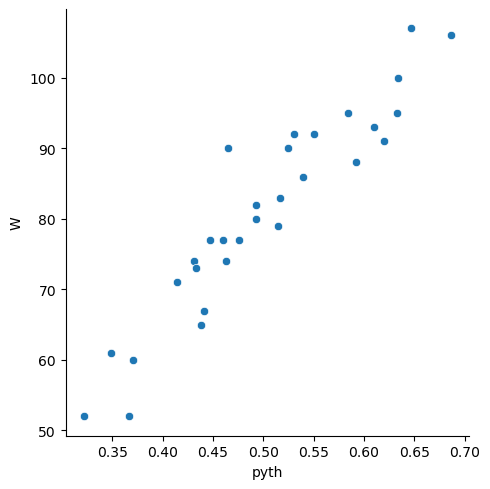

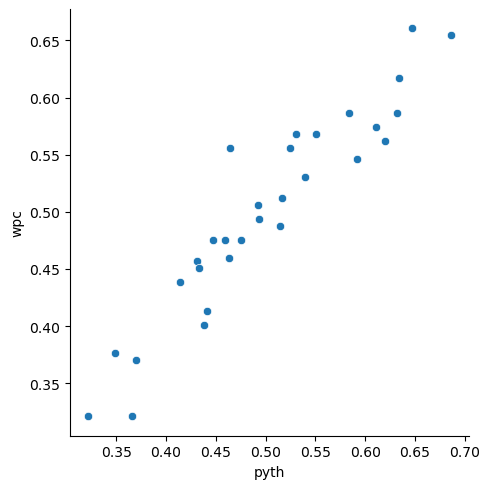

In [61]:
# Generate and xy plot use the Seaborn package.
# This illustrates nicely the close correlation between win percentage and the Pythagorean Expectation.

sns.relplot(x="pyth", y="W", data = MLB21)
sns.relplot(x="pyth", y="wpc", data = MLB21)
plt.show()

# 產生回歸
## 擬合一個回歸方程來觀察畢達哥拉斯期望值每增加一個單位，獲勝百分比增加多少。
The regression output tells you many things about the fitted relationship between win percentage and the Pythagorean Expectation. Regression is a method for identifying an equation which best fits the data. In this case that relationship is

### wpc = Intercept + coef x pyth

You can see the value of Intercept is 0.0609 and coef is .8770. It's this latter value were interested in. It means that for every one unit increase in pyth, the value of wpc goes up by 0.887.

Two other points to note:

(i) The standard error (std err) gives us an idea of the precision of the estimate. The ratio of the coefficient (coef) to the standard error is called the t statistic (t) and its value informs us about statistical significance. This is illustrated by the p-value (P > |t|) - this is the probability that we would observe the value .8770 by chance, if the true value were really zero. This probability here is 0.000 - (this is not exactly zero, but the table doesn't include enough decimal places to show this) which means we can confident it is not zero. By convention, it is usual to conclude that we cannot be confident that the value of the coefficient is not zero if the p-value is greater than .05

(ii) in the top right hand corner of the table is the R-squared. This statistic tells you the percentage of variation in the y-variable (wpc) which can be accounted for by the variation in the x variables (pyth). R-squared can be thought of as a percentage - here the Pythagorean Expectation can account for 89.4% of the variation in win percentage



簡單回歸分析: https://itunesu-assets.itunes.apple.com/itunes-assets/CobaltPublic3/v4/c8/17/33/c8173335-c4c1-3024-44b8-3a18ac0db16c/311-1510642810498401148-11.1_11.5.pdf?a=v%3D3%26artistId%3D1280875126%26podcastId%3D1045845504%26podcastName%3D%25E7%25B5%25B1%25E8%25A8%2588%25E5%25AD%25B8%2528%25E4%25BA%258C%2529%2BStatistics%2BII%2B%253A%2B%25E9%2580%25B2%25E9%259A%258E%25E7%25B5%25B1%25E8%25A8%2588%26episodeId%3D1000353807939%26episodeName%3D%2528%25E8%25AC%259B%25E7%25BE%25A9%2529%2B%25E7%25AC%25AC%25E5%258D%2581%25E4%25B8%2580%25E7%25AB%25A0%2B%25E7%25B0%25A1%25E5%2596%25AE%25E5%25BB%25BB%25E6%25AD%25B8%25E5%2588%2586%25E6%259E%2590%25E8%2588%2587%25E7%259B%25B8%25E9%2597%259C%25E5%2588%2586%25E6%259E%2590%2B11.1%2B-%2B11.5%26episodeKind%3Dpdf%26pageLocation%3Ditc

![jupyter](https://miro.medium.com/max/640/1*eBtPUiqFE74w2Dmmv-YV7Q.webp)

####  *intercept截距
#### *coef係數項: X 單位變化時Y的變化
#### *判定係數r2 (Coefficient of Determination)：判定係數是用來衡量自變數(X)所能解釋因變數(Y)之變異量占Y總變異量的百分比(0≦r2≦1)。
####  *標準誤差std err: 標準誤差顯示這些參數的採樣變異性
https://www.4k8k.xyz/article/qq_29983883/116355923

In [63]:
# Finally we generate a regression.
# tatsmodels.formula.api要求用户输入公式，公式的形式为“parameter1 ~ parameter2”，parameter1是因變數(y1)，parameter2则是自變數
pyth_lm = smf.ols(formula = 'wpc ~ pyth', data=MLB21).fit()
pyth_lm.summary()
##  Intercept(截距) 的值為 0.0555，係數(斜率)為 0.8865。表示畢達哥拉斯期望值每增加一個單位，獲勝百分比的值就會增加 0.8865。

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wpc   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     217.3
Date:                Sat, 10 Dec 2022   Prob (F-statistic):           1.01e-14
Time:                        00:45:49   Log-Likelihood:                 62.961
No. Observations:                  30   AIC:                            -121.9
Df Residuals:                      28   BIC:                            -119.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0555      0.031      1.811      0.081      -0.007       0.118
pyth           0.8865      0.060     14.743      0.000       0.763       1.010
==============================================================================
Omnibus:                        3.573   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.168   Jarque-Bera (JB):                2.084
Skew:                           0.480   Prob(JB):                        0.353
Kurtosis:                       3.864   Cond. No.                         13.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# OLS regression results

(i) Intercept(截距) 的值為 0.0555，係數(斜率)為 0.8865。表示畢達哥拉斯期望值每增加一個單位，獲勝百分比的值就會增加 0.8865。

(ii) 在表格的右上角是 R 平方。該統計數據告訴您 y 變量 (wpc) 的變化百分比，這可以由 x 變量 (pyth) 的變化來解釋。R 平方可以被認為是一個百分比——在這裡，畢達哥拉斯期望值可以佔勝率變化的 88.6%。

https://blog.csdn.net/BF02jgtRS00XKtCx/article/details/108687817